In [4]:
!pip install imbalanced-learn


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Embedding, Conv1D, MaxPooling1D, BatchNormalization,
    Bidirectional, LSTM, Dense, Dropout, GlobalAveragePooling1D,
    SpatialDropout1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [6]:
dataset = load_dataset("AI4Protein/GO_MF")

train_data = dataset["train"]
test_data  = dataset["test"]

X_raw = train_data["aa_seq"]
Y_raw = train_data["label"]

X_test_raw = test_data["aa_seq"]
Y_test_raw = test_data["label"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/6.90M [00:00<?, ?B/s]

valid.csv:   0%|          | 0.00/755k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/1.28M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/22081 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2432 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3350 [00:00<?, ? examples/s]

In [7]:
mlb = MultiLabelBinarizer()
Y_encoded = mlb.fit_transform(Y_raw)
Y_test_encoded = mlb.transform(Y_test_raw)

num_classes = len(mlb.classes_)
print("Number of GO molecular functions:", num_classes)


Number of GO molecular functions: 11


In [8]:
label_to_function = {
    0: "ATP binding",
    1: "Protein kinase activity",
    2: "Transferase activity",
    3: "Nucleotide binding",
    4: "Catalytic activity",
    5: "Hydrolase activity",
    6: "Ligase activity",
    7: "Oxidoreductase activity",
    8: "Transporter activity",
    9: "Binding"
}

function_names = [
    label_to_function.get(i, f"Function_{i}")
    for i in range(num_classes)
]


In [9]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_raw)

X_seq = tokenizer.texts_to_sequences(X_raw)
X_test_seq = tokenizer.texts_to_sequences(X_test_raw)


In [10]:
MAX_LEN = 500   # fixes overfitting

X_pad = pad_sequences(X_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding="post", truncating="post")

vocab_size = len(tokenizer.word_index) + 1


In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X_pad, Y_encoded, test_size=0.1, random_state=42
)


In [12]:
label_count = Y_train.sum(axis=1)
label_count = label_count.astype(int)

# RandomOverSampler does not support multilabel targets directly.
# Proceeding without oversampling for now. If imbalance is an issue,
# other strategies for multilabel data should be explored.
X_train_bal = X_train
Y_train_bal = Y_train

print("Before balancing:", X_train.shape)
print("After balancing :", X_train_bal.shape)


Before balancing: (19872, 500)
After balancing : (19872, 500)


In [13]:
input_layer = Input(shape=(MAX_LEN,))

embedding = Embedding(
    input_dim=vocab_size,
    output_dim=128,
    embeddings_regularizer=l2(1e-5)
)(input_layer)

embedding = SpatialDropout1D(0.3)(embedding)

cnn = Conv1D(
    128, kernel_size=5, padding="same",
    activation="relu", kernel_regularizer=l2(1e-4)
)(embedding)
cnn = BatchNormalization()(cnn)
cnn = MaxPooling1D(2)(cnn)

lstm = Bidirectional(
    LSTM(128, return_sequences=True, dropout=0.3)
)(cnn)

pool = GlobalAveragePooling1D()(lstm)

dense = Dense(
    256, activation="relu", kernel_regularizer=l2(1e-4)
)(pool)
dense = Dropout(0.5)(dense)

output = Dense(num_classes, activation="sigmoid")(dense)

model = Model(input_layer, output)

model.compile(
    optimizer=Adam(learning_rate=5e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 128)       │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 500, 128)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 500, 128)       │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 500, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 250, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 250, 256)       │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         2,827 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,035 (1.59 MB)

 Trainable params: 416,779 (1.59 MB)

 Non-trainable params: 256 (1.00 KB)

In [14]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train_bal, Y_train_bal,
    validation_data=(X_val, Y_val),
    epochs=30,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.2700 - loss: 0.6842 - val_accuracy: 0.8737 - val_loss: 0.6798 - learning_rate: 5.0000e-05
Epoch 2/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 40ms/step - accuracy: 0.6394 - loss: 0.6400 - val_accuracy: 0.8610 - val_loss: 0.6365 - learning_rate: 5.0000e-05
Epoch 3/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.6755 - loss: 0.6389 - val_accuracy: 0.8737 - val_loss: 0.6271 - learning_rate: 5.0000e-05
Epoch 4/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.7128 - loss: 0.6329 - val_accuracy: 0.8606 - val_loss: 0.6212 - learning_rate: 5.0000e-05
Epoch 5/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7314 - loss: 0.6309 - val_accuracy: 0.8719 - val_loss: 0.6184 - learning_rate: 5.0000e-05
Epoch 6/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/step - accuracy: 0.7295 - loss: 0.6279 - val_accuracy: 0.8732 - val_loss: 0.6160 - learning_rate: 5.0000e-05
Epoch 7/30
311/311 ━━━━━━━━━━━━━━━━━━━━ 13s 42ms/ste

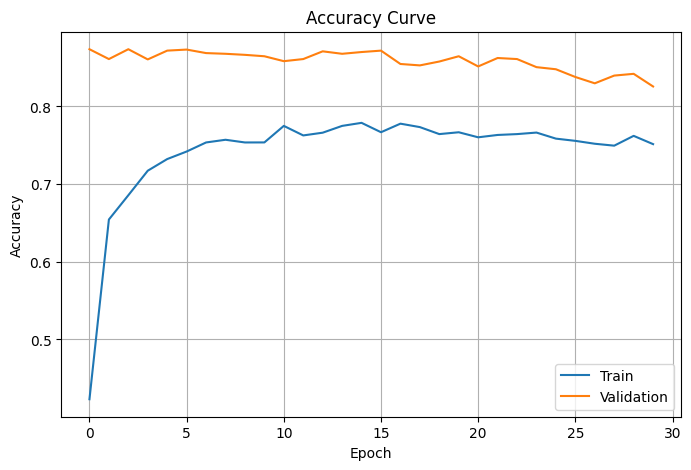

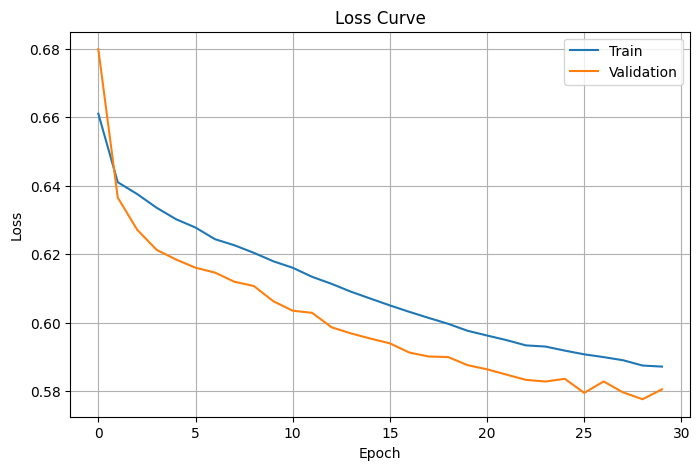

In [15]:
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()


In [16]:
Y_probs = model.predict(X_test_pad)
Y_pred = (Y_probs >= 0.3).astype(int)

loss, keras_acc = model.evaluate(X_test_pad, Y_test_encoded, verbose=0)
subset_acc = accuracy_score(Y_test_encoded, Y_pred)

print("\n===== ACCURACY =====")
print("Test Loss       :", round(loss, 4))
print("Keras Accuracy  :", round(keras_acc, 4))
print("Subset Accuracy :", round(subset_acc, 4))


105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

===== ACCURACY =====
Test Loss       : 0.5161
Keras Accuracy  : 0.9206
Subset Accuracy : 0.2633


In [17]:
print("\n===== PERFORMANCE =====")
print("Micro Precision:", precision_score(Y_test_encoded, Y_pred, average="micro"))
print("Micro Recall   :", recall_score(Y_test_encoded, Y_pred, average="micro"))
print("Micro F1       :", f1_score(Y_test_encoded, Y_pred, average="micro"))



===== PERFORMANCE =====
Micro Precision: 0.8138987369820518
Micro Recall   : 0.9908618829241974
Micro F1       : 0.8937043795620438


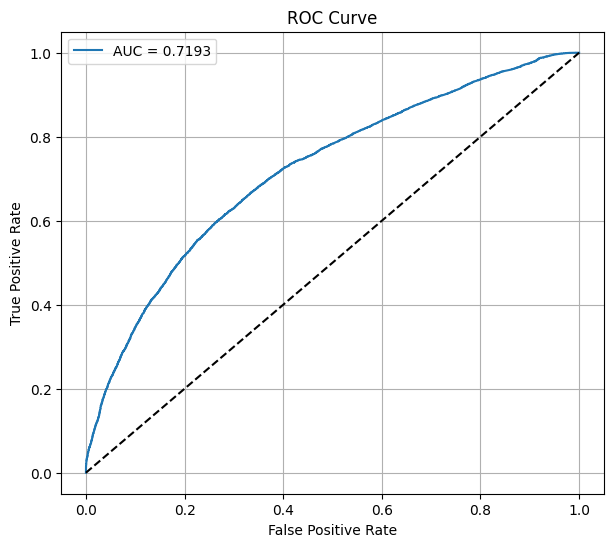

In [18]:
fpr, tpr, _ = roc_curve(Y_test_encoded.ravel(), Y_probs.ravel())
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [19]:
def predict_protein_function(sequence, top_k=5):
    seq = tokenizer.texts_to_sequences([sequence])
    seq = pad_sequences(seq, maxlen=MAX_LEN, padding="post")
    probs = model.predict(seq)[0]

    top_idx = np.argsort(probs)[-top_k:][::-1]

    print("\nPredicted Protein Functions:\n")
    for i in top_idx:
        print(f"{function_names[i]} | Confidence: {probs[i]:.4f}")


In [20]:
predict_protein_function("MKTFFVAGVALLLSHAA")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step

Predicted Protein Functions:

ATP binding | Confidence: 0.7208
Nucleotide binding | Confidence: 0.6901
Catalytic activity | Confidence: 0.6874
Transferase activity | Confidence: 0.6812
Ligase activity | Confidence: 0.6259
